# 🏠 House Price Prediction - Preprocessing & Feature Engineering

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Drop high-missing columns
missing_thresh = 0.4
missing_ratio = train.isnull().mean()
drop_cols = missing_ratio[missing_ratio > missing_thresh].index
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

# Fill missing values
# for col in train.columns:
#     if train[col].dtype == 'object':
#         train[col].fillna("Missing", inplace=True)
#         test[col].fillna("Missing", inplace=True)
#     else:
#         train[col].fillna(train[col].median(), inplace=True)
#         test[col].fillna(test[col].median(), inplace=True)

for col in train.columns:
    if col not in test.columns:
        continue  # Skip columns like 'SalePrice' that aren't in test

    if train[col].dtype == 'object':
        train[col].fillna("Missing", inplace=True)
        test[col].fillna("Missing", inplace=True)
    else:
        train[col].fillna(train[col].median(), inplace=True)
        test[col].fillna(test[col].median(), inplace=True)


# Encode categorical features
# cat_cols = train.select_dtypes(include='object').columns
# le = LabelEncoder()
# for col in cat_cols:
#     train[col] = le.fit_transform(train[col])
#     test[col] = le.transform(test[col])

from sklearn.preprocessing import LabelEncoder

cat_cols = train.select_dtypes(include='object').columns
le = LabelEncoder()

for col in cat_cols:
    # Combine train and test to fit on all possible labels
    full_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(full_data)

    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))


# Transform target
train['SalePrice'] = np.log1p(train['SalePrice'])

# Train-test split
X = train.drop(['Id', 'SalePrice'], axis=1)
y = train['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE:", rmse)

# Predict on test set and create submission file
final_preds = model.predict(test.drop(['Id'], axis=1))
final_preds = np.expm1(final_preds)  # Reverse log1p

submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': final_preds
})
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv generated!")


Validation RMSE: 0.15453451787279943
✅ submission.csv generated!


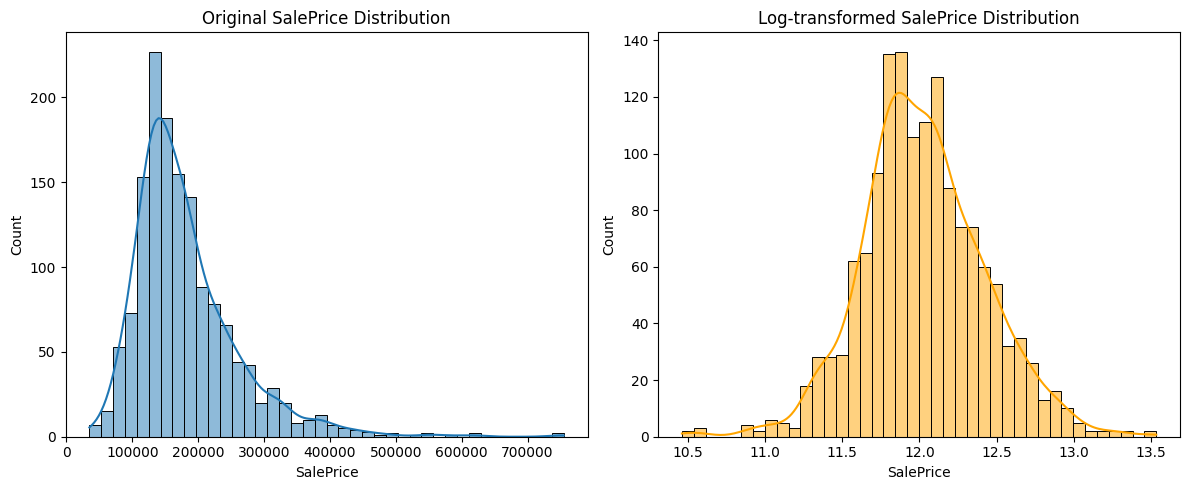

In [11]:

# 📊 Visualize SalePrice distribution before and after log transformation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(np.expm1(train['SalePrice']), kde=True, bins=40)
plt.title('Original SalePrice Distribution')

plt.subplot(1, 2, 2)
sns.histplot(train['SalePrice'], kde=True, bins=40, color='orange')
plt.title('Log-transformed SalePrice Distribution')

plt.tight_layout()
plt.show()


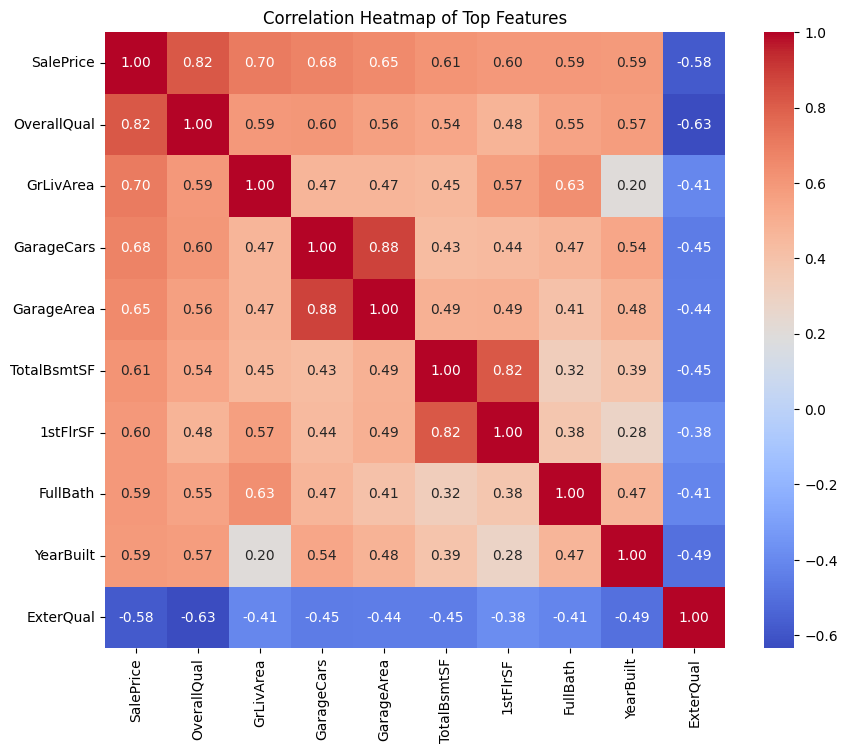

In [12]:

# 📈 Correlation heatmap of top correlated features
corr = train.corr(numeric_only=True)
top_corr_features = corr['SalePrice'].abs().sort_values(ascending=False).head(10).index
plt.figure(figsize=(10, 8))
sns.heatmap(train[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Top Features')
plt.show()


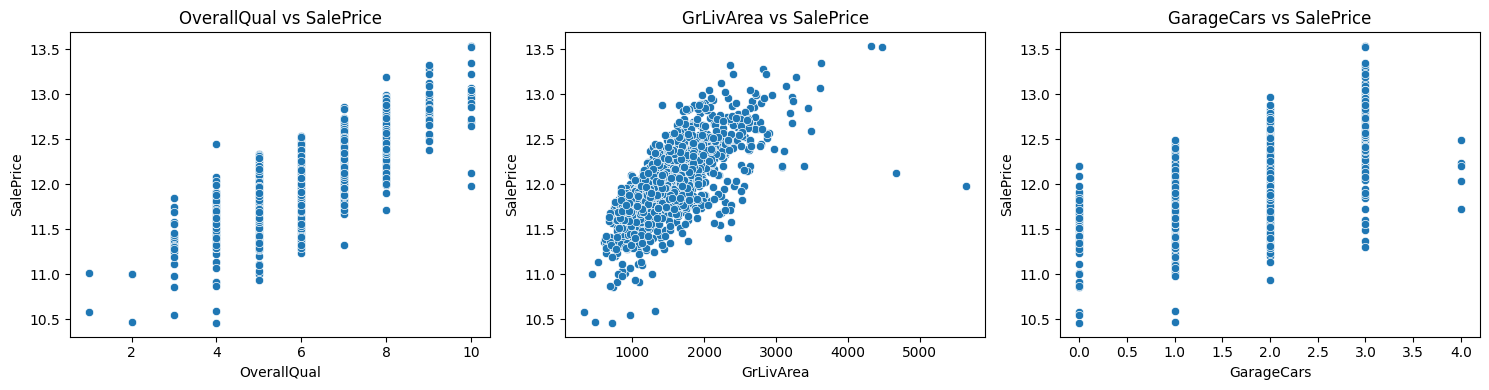

In [13]:

# 📉 Scatter plots for top 3 correlated features vs SalePrice
top_features = top_corr_features.drop('SalePrice')[:3]
plt.figure(figsize=(15, 4))
for i, feature in enumerate(top_features):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=train[feature], y=train['SalePrice'])
    plt.title(f"{feature} vs SalePrice")
plt.tight_layout()
plt.show()
